# Simple Linear Regression with OLS (Ordinary Least Squares)

Regression tasks are those where you need an algorithm that ultimately outputs continuous numerical values.  There are a number of ways to produce this kind of output, but the simplest and most commonly used method is linear regression.  You will explore how to formulate a linear regression model and estimate it using the Ordinary Least Squares (OLS) method.

Although it is not the only approach, OLS is by far the most common method of estimating linear regression models.  This technique is so common and canonical that people will often refer to it simply as "regression", even though there are plenty of other techniques and types of models that qualify as regressions.  Covered is the basic formulation of linear regression models and the OLS algorithm.

Specifically, these topics are covered in this notebook:
- General formulation of linear regression models
- Ordinary Least Squares (OLS)
- How to find optimal coefficients for a linear regression model
- How to implement a linear regression model in sklearn

## Formulating a Linear Regression Model

Previously, in 19.01, it was illustrated that linear regression models plot a line of best fit representing the relationship between the features and the target. Precisely, a linear regression model can be formulated mathematically like this: $ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon \qquad(eq.1) $

In $ (eq.1) $, $ y $ represents the target variable and $ x_1, x_2, \dots, x_n $s represent the features.  $ n $ denotes the number of features.  The unknowns of (eq.1) are the $ \beta $ terms.  $ \beta_0 $ refers to the __intercept__ (aka. __bias__ or __constant__).  All the other $ \beta $s are the coefficients.  $ \epsilon $ is the __error term__ (aka __residual__), which represents the information in $ y $ that is unexplained by the features.

This expression can be written concisely using $ \sum $: $$ y = \beta_0 + \sum_{i=1}^{n}\beta_ix_i + \epsilon \qquad(eq.2) $$ 

In $ (eq.2) $, $\sum_{i=1}^{n}$ adds up each $\beta_ix_i$ where the subscript $i$ refers to the index of the features and the coefficients. Hence $\sum_{i=1}^{n}$ starts from $i=1$ and goes until $i=n$.

\* In linear regression models, it is common to refer to features in a model as __explanatory variables__ or __independent variables__ and the target variable as the __explained__ or __dependent variable__. 

 ## Insurance Charges Dataset

 This demonstration of linear regression modeling will be performed on a medical cost dataset from Kagle.  The original dataset is called "Medical Cost Personal Dataset".  The data is about the costs charged by insurance companies to individuals.  These are costs that the insured individuals were required to pay after the insurance company made payments to medical providers.  The dataset includes six variables: 
 
   | Variable Name         | Variable Description              | Data Type                   |
   | :-------------------- | :-------------------------------- | :-------------------------- |
   | age                   | The age of the individual         | Numeric                     |
   | sex                   | The biological sex of the insured | Categorical: (male / female) |
   | BMI (Body Mass Index) | index indicates whether an individual's weight is relatively high or low, based on height. This index defines an ideal range between 18.5 and 24.9. | Continuous |
   | children | How many dependent children the insured person has. Dependents are covered by the insurance plan. | Numeric |
   | smoker | Indicates whether or not the person smokes. | Categorical: (yes / no) |
   | region | The person's residential area in the US. | Categorical: (northeast, southeast, southwest, northwest) |
   | charges | The medical costs (in US dollars) billed by the insurance company. | Continuous | 

In the examples the target variable is "charges" billed by the insurance company.  Since it is a continuous variable, this is a regression task.

## Preliminary Data Exploration 

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import warnings 

from sklearn import linear_model
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL

warnings.filterwarnings('ignore')

kagle = dict(
    drivername = 'postgresql',
    username = 'dsbc_student',
    password = '7*.8G9QH21',
    host = '142.93.121.174',
    port = '5432',
    database = 'medicalcosts',
)

In [6]:
# Load the data from the "medicalcosts" database and display some observations

engine=create_engine(URL(**kagle), echo=True)

insurance_df = pd.read_sql_query("SELECT * FROM medicalcosts", con=engine)

engine.dispose()

2019-12-23 14:07:19,961 INFO sqlalchemy.engine.base.Engine select version()
2019-12-23 14:07:19,962 INFO sqlalchemy.engine.base.Engine {}
2019-12-23 14:07:20,064 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-12-23 14:07:20,066 INFO sqlalchemy.engine.base.Engine {}
2019-12-23 14:07:20,166 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-12-23 14:07:20,167 INFO sqlalchemy.engine.base.Engine {}
2019-12-23 14:07:20,217 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-12-23 14:07:20,218 INFO sqlalchemy.engine.base.Engine {}
2019-12-23 14:07:20,268 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-12-23 14:07:20,270 INFO sqlalchemy.engine.base.Engine {}
2019-12-23 14:07:20,373 INFO sqlalchemy.engine.base.Engine SELECT * FROM medicalcosts
2019-12-23 14:07:20,374 INFO sqlalchemy.engine.base.Engine {}


In [7]:
insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.90
1,18,male,33.770,1,no,southeast,1725.55
2,28,male,33.000,3,no,southeast,4449.46
3,33,male,22.705,0,no,northwest,21984.50
4,32,male,28.880,0,no,northwest,3866.86
5,31,female,25.740,0,no,southeast,3756.62
6,46,female,33.440,1,no,southeast,8240.59
7,37,female,27.740,3,no,northwest,7281.51
8,37,male,29.830,2,no,northeast,6406.41
9,60,female,25.840,0,no,northwest,28923.10


First, take a look at the distribution of the target variable: charges.  Investigating how the target variable is distributed helps you to understand the relationship between the target and the features.  It's also useful to discover some potential problems with the model.

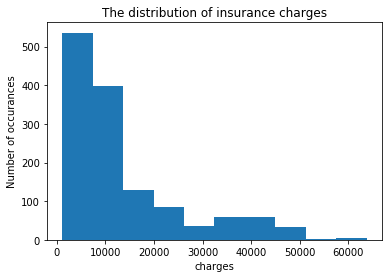

In [8]:
plt.hist(insurance_df["charges"])
plt.title("The distribution of insurance charges")
plt.xlabel("charges")
plt.ylabel("Number of occurances")
plt.show()

Observe that "charges" is not normally distributed.  Instead, it is highly skewed.  __Skewness__ is a measure of how asymmetric the data is with respect to the normal distribution.  As seen in the plot, the "charges" variable is not symmetric but skewed to the right.  The majority of the observations have low charges values and few of the observations have high charges values.  This makes the distribution of the charges clustered at the left-most part of the histogram.

Notice that the categorical variables (sex, smoker, & region) are strings and need to be converted to numerical values.  This is part of the feature engineering process.  One of the most convenient ways of converting categorical variables into numerical ones is called __one hot encoding__.  In one hot encoding, you create a separate binary variable which 0 or 1 for each of the unique values of the categorical variable.  Pandas' `get_dummies()` function will accomplish this.

In the cell below, call the `get_dummies()` function for the "sex" and "smoker" categorical variables.  Both "sex" and "smoker" variables include two values, the `get_dummies()` function will create two dummy (indicator) variables.  Since only one is necessary to indicate wether a person is male or not and is a smoker or not, you only need to keep one of the newly created dummies_bot for "sex" and "smoker" in the dataframe.  This is accomplished by feeding the parameter `drop_first` which is set to `True` into the `get_dummies()` function.

In [9]:
insurance_df["is_male"] = pd.get_dummies(insurance_df["sex"], drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df["smoker"], drop_first=True)

Take a look at the newly created variables (is_male and is_smoker), at first glance, gender and smoking may play an important role in the insurance charges.  Take a look at wether you see some differences between the average costs billed to different genders and to the ones who smoke.

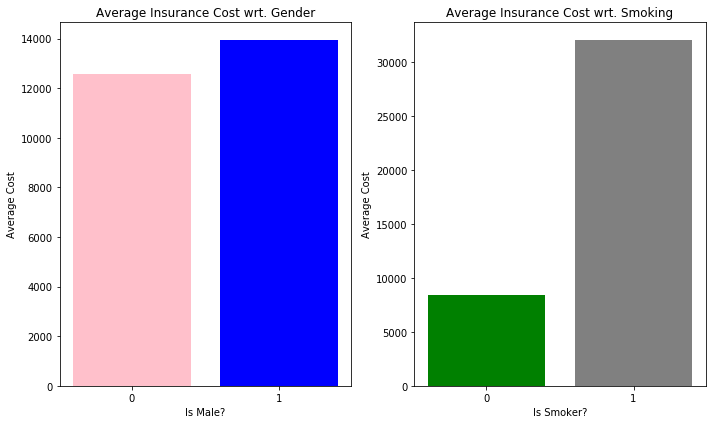

In [11]:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.bar(
    insurance_df.groupby("is_male")["charges"].mean().index, 
    insurance_df.groupby("is_male")["charges"].mean(), 
    color=("pink","blue")
)
plt.title("Average Insurance Cost wrt. Gender")
plt.ylabel("Average Cost")
plt.xlabel("Is Male?")
plt.xticks([0,1])

plt.subplot(1,2,2)
plt.bar(
    insurance_df.groupby("is_smoker")["charges"].mean().index, 
    insurance_df.groupby("is_smoker")["charges"].mean(), 
    color=("green","grey")
)
plt.title("Average Insurance Cost wrt. Smoking")
plt.ylabel("Average Cost")
plt.xlabel("Is Smoker?")
plt.xticks([0,1])

plt.tight_layout()
plt.show();

As seen, the average costs seem to be different each group.  That is to say, on average, males seem to be charged more then females and smokers are charged more than non-smokers.  Now, build a first model using these two features.

## Modeling the Insurance Charges with Linear Regression 

Illustrate how you can model the insurance cost using a simple linear regression mode.  The target variable is "charges" and you include two categorical variables as the features: "is_male" and "is_smoker".  Hence the model becomes: $ charges = \beta_0 + \beta_1 is\_smoker + \beta_2 is\_male + \epsilon \qquad(eq.3) $.  In $ (eq.3) $, $ \beta_0 $ is the constant and $ \beta_1 $ and $ \beta_2 $ are the coefficients of the "is\_smoker" and "is\_male" dummies respectively.

\* Note on the bias term: Putting a constant in a model is optional, but it's a good idea to include a constant in every model you build.  Even if you believe the constant to be zero, letting OLS decide wither it is zero is not the safest way.

## How to Find the Optimal Values for Coefficients?

Formulating a model is the first step in a regression problem.  But, you need to find a way to discover the optimal values for the unknowns (the coefficients) in $ (eq.3) $.  Recall that the process of finding the optimal values of the unknowns is called __optimization__.  Here you need an optimization algorithm to solve for the optimal coefficient values.  The most common optimization algorithm used in linear regression models is __Ordinary Least Squares__ or __OLS__.

## The Machinery of OLS

OLS tries to minimize the squared sums of the error terms ($ \epsilon $) in the model.  The error term can be written as: $ (y - \beta_0 - \sum_{i=1}^{n}\beta_ix_i ) = \epsilon \qquad(eq.4) $.  If you take the square of each side it becomes: $(y - \beta_0 - \sum_{i=1}^{n}\beta_ix_i )^2 = \epsilon^2 \qquad(eq.5)$.  Notice that this error term is for a single observation.  If you have $ m $ observations in the dataset, then sum of the squared errors can be represented like this: $\sum_{j=1}^{m}(y_j - \beta_0 - \sum_{i=1}^{n}\beta_ix_{ij} )^2 = \sum_{j=1}^{m}\epsilon_j^2 \qquad(eq.6)$.  Recall that $ i $ was representing the index of the features in the model.  In $ (eq.6) $, $ j $ represents the index of the observations.  Hence, you go over each observation and add up their squared error terms.  Using matrix notation simplifies the expression: $(Y - \beta X)^2 = \mathcal{E}^2 \qquad(eq.7)$.  This exploration will not go deeper into the derivation of the coefficients, all you need to do is to take the derivative of both sides with respect to each coefficient and equate them to zero!  If you solve the resulting equations, then you end up with the optimal values of the coefficients: $ \hat{\beta} = (X^TX)^{-1}X^TY \qquad(eq.8)$.  In $ (eq.8) $, $ \hat{\beta} $ indicates the estimated coefficients vector, $ X^T $ refers to the transpose of the feature matrix (X), and superscript $ ^{-1} $ refers to the inverse of a matrix.

That's it! If you want to learn more about the derivation steps, you can read the [Wikipedia article](https://en.wikipedia.org/wiki/Ordinary_least_squares).

## An Initial Model for Insurance Charges

Using $ (eq.3) $ above, you can build a simple linear regression model and estimate it using OLS.  Here, the statsmodels package will be used for regression analysis.  Using statsmodels for fitting linear regression models might be easier because of it's `summary()` function.  The function outputs many important metrics in tabular form, getting the same metrics in scikit-learn requires more work.

First, though demonstrate how you fit linear regression models in scikit-learn.  Use `LinearRegression()` from the `linear_model` module:  

In [12]:
# Y is the target variable
Y = insurance_df["charges"]

# X is the feature set which includes: is_male and is_smoker
X = insurance_df[["is_male","is_smoker"]]

# Create a LinearRegression model object from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates of the coefficients using OLS
lrm.fit(X,Y)

# inspect the results
print("\nCoefficients: \n", lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [  -65.37868556 23622.13598049]

Intercept: 
 8466.035592512448


`LinearRegression()`'s `fit()` method runs the OLS algorithm by default.  Since you get the parameters by using OLS, you can estimated model: $ charges = 8466.04 + -65.38 is\_male + 23622.14 is\_smoker \qquad(eq.9) $

According to the estimation results, the constant term is 8466.04.  The estimated coefficients of the is\_male and is\_smoker features are -65.38 and 23622.14, respectively.  The particulars of how to interpret these estimated coefficients will be covered later.

This time run the same model using statsmodels.

In [13]:
import statsmodels.api as sm 

# Need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1088.
Date:                Mon, 23 Dec 2019   Prob (F-statistic):          4.78e-281
Time:                        20:29:36   Log-Likelihood:                -13831.
No. Observations:                1338   AIC:                         2.767e+04
Df Residuals:                    1335   BIC:                         2.768e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8466.0356    303.541     27.891      0.000    7870.566    9061.506
is_male      -65.3787    409.809     -0.160      0.873    -869.318     738.561
is_smoker   2.362e+04    507.736     46.524      0.000    2.26e+04    2.46e+04
==============================================================================
Omnibus:                      135.842   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.897
Skew:                           0.727   Prob(JB):                     9.71e-47
Kurtosis:                       4.299   Cond. No.                         2.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Second, when you call the `summary()` function on the fitted OLS model, it prints out a table of statistics.  For example, in the upper right-side you see statistics like R-squared, adjusted R-squared, F-statistic, Log-likelyhood, AIC, and BIC.  Those are related to the goodness of fit of the model.  In the lower part, you see statistics like Durbin-Watson, Jarque-Bera, skewness, and kurtosis.  Those statistics are related to whether the model satisfies some assumptions of the linear regression model but more about these later.  For now notice, that in the middle of the table, estimated values for the coefficients are given, and those are exactly the same as what was returned from scikit-learn.

## Assignment: Predicting House Prices

Now, it's your turn to design your first regression model.  You'll be using a version of the "House Prices" dataset from Kaggle from a Postgres database.  This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa.  Using this data, you task will be to predict the prices of the houses.  You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

To complete this assignment, create a Jupyter notebook containing your solutions to the following tasks:

* Load the dataset from the Thinkful PostgreSQL database. You can look at the example above for inspiration on how to generate the database engine URL. You'll need the following values:

```python
        postgres_user = 'dsbc_student'
        postgres_pw = '7*.8G9QH21'
        postgres_host = '142.93.121.174'
        postgres_port = '5432'
        postgres_db = 'houseprices'
```

* Please follow the example above and call `engine.dispose()` when you no longer need to make db queries. You need to be in the habit of responsibly managing database connections, and the database only supports a limited number of connections.
* Investigate the data, and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in predicting house prices.
* Build your initial model using these features and estimate the parameters using OLS.


Spend up to 4 hours on this assignment. When you are done and have submitted a link to your notebook below, feel free to take a look at [this example solution](https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/2.solution_simple_linear_regression_models.ipynb).